# **Recognition of constellations in images of the night sky**

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import morphology, measure
from math import *
import math

In [8]:
def thresholding(f, L):
    # create a new image with zeros
    f_tr = np.ones(f.shape).astype(np.uint8)
    # setting to 1 the pixels above the threshold
    f_tr[np.where(f < L)] = 0
    return f_tr

The function bellow draws a line between two points in a matrix

In [9]:
def draw_line(mat, x0, y0, x1, y1, inplace=False):
    
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
        
    if not inplace:
        mat = mat.copy()
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 1
        return mat if not inplace else None
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Write line ends
    mat[x0, y0] = 1
    mat[x1, y1] = 1
    
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 255
    mat[x+1, y] = 255
    mat[x-1, y] = 255
    mat[x, y+1] = 255
    mat[x, y-1] = 255
    mat[x+1, y+1] = 255
    mat[x-1, y-1] = 255
    
    if not inplace:
        return mat if not transpose else mat.T

The functions bellow recognize clusters of stars

In [10]:
def getAndRemoveNeighboors(curPixelPos, whitePixels, pixelsToBeProcessed, pixelCluster):          
        neighboors = {(curPixelPos[0]-1, curPixelPos[1]-1), (curPixelPos[0]-1, curPixelPos[1]), (curPixelPos[0]-1, curPixelPos[1]+1),
                      (curPixelPos[0], curPixelPos[1]-1),   (curPixelPos[0], curPixelPos[1]),   (curPixelPos[0], curPixelPos[1]+1),
                      (curPixelPos[0]+1, curPixelPos[1]-1), (curPixelPos[0]+1, curPixelPos[1]), (curPixelPos[0]+1, curPixelPos[1]+1)
                     }
        
        if (pixelCluster.count(curPixelPos) == 0):
            pixelCluster.append(curPixelPos)
            
        for p in neighboors:
            if p in whitePixels:
                pixelsToBeProcessed.append(p)
                pixelCluster.append(p)
                whitePixels.remove(p)
        
        return whitePixels, pixelsToBeProcessed, pixelCluster

# retorna grupos de pixels brancos adjacentes
def clustering(img):
    whitePixels = set()
    recognizedClusters = []
    
    n, m = img.shape
    for x in range(n):
        for y in range(m):
            if (img[x,y] == 1):
                whitePixels.add(tuple([x,y]))
                
    while (len(whitePixels) != 0):
        pixelCluster = []
        pixelsToBeProcessed = []
        
        p = whitePixels.pop()
        pixelsToBeProcessed.append(p)
        
        while (len(pixelsToBeProcessed) != 0):
            curPixel = pixelsToBeProcessed[0]
            whitePixels, pixelsToBeProcessed, pixelCluster = getAndRemoveNeighboors(curPixel, whitePixels, pixelsToBeProcessed, pixelCluster)
            pixelsToBeProcessed.remove(curPixel)
    
        recognizedClusters.append(pixelCluster)
    
    return recognizedClusters

Functions that calculate the angle between two points and two lines

In [11]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1] 
    
def slope(x1, y1, x2, y2): # Line slope given two points:
    return (y2-y1)/(x2-x1)

def angle(s1, s2): 
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))

# Calculate the angles between the lines that connect the 3 brightest stars (making a triangle)  
def triangle_angles(stars):
    lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
    lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
    lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

    slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
    slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
    slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

    a1 = abs(angle(slope1, slope2))
    a2 = abs(angle(slope1, slope3))
    a3 = abs(angle(slope3, slope2))

    triangle = []
    triangle.append(a1)
    triangle.append(a2)
    triangle.append(a3)
    triangle.sort()
    
    return triangle

### We will now test the functions for different constellations:

## Orion Constellation:

    

Text(0.5, 1.0, 'thresholded image')

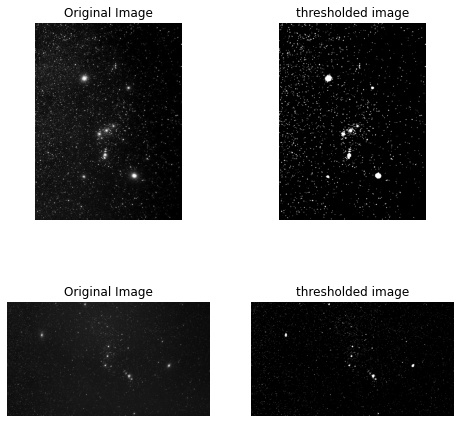

In [12]:
image1 = imageio.imread('Images/Orion/0c9805f82c456d53d99b56f7ed960e9d.jpg', as_gray=True)
image2 = imageio.imread('Images/Orion/Orion-Betelgeuse.jpg', as_gray=True)

img_o1 = thresholding(image1,80)
img_o2 = thresholding(image2,80)

plt.figure(figsize=(8,8))
plt.subplot(221); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(222); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(223); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(224); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

[11.683869601099866, 30.034555868848123, 41.71842546994799]


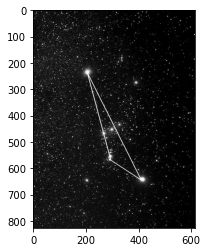

In [13]:
S = clustering(img_o1)
stars = sorted(S, key=len)
stars.reverse()

# Drow the lines between the 3 brightest spots forming a triangle
img_line = draw_line(image1, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

# Find the angles
triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

[11.186290999117137, 26.339063210750243, 37.52535420986738]


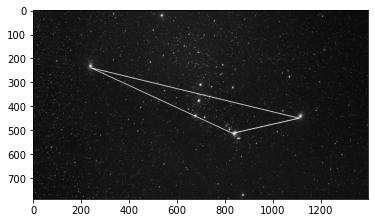

In [14]:
S = clustering(img_o2)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(image2, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

# Find the angles
triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

## Constelação Ursa Minor:

Text(0.5, 1.0, 'thresholded image')

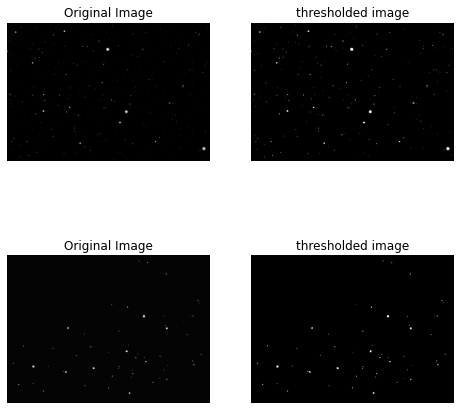

In [16]:
image1 = imageio.imread('Images/UrsaMinor/con_UMI_001.png', as_gray=True)
image2 = imageio.imread('Images/UrsaMinor/unnamed.jpg', as_gray=True)

img_o1 = thresholding(image1,80)
img_o2 = thresholding(image2,80)

plt.figure(figsize=(8,8))
plt.subplot(221); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(222); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(223); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(224); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

[19.271488170232043, 27.629968577075562, 46.901456747307606]


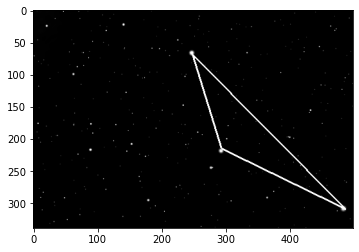

In [17]:
S = clustering(img_o1)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(image1, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

[21.300927709719495, 25.88951474805126, 47.190442457770764]


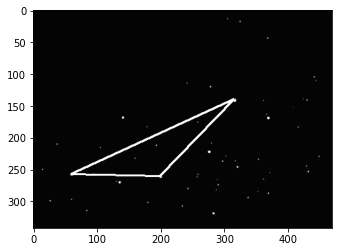

In [18]:
S = clustering(img_o2)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(image2, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

## Ursa Major:

Text(0.5, 1.0, 'thresholded image')

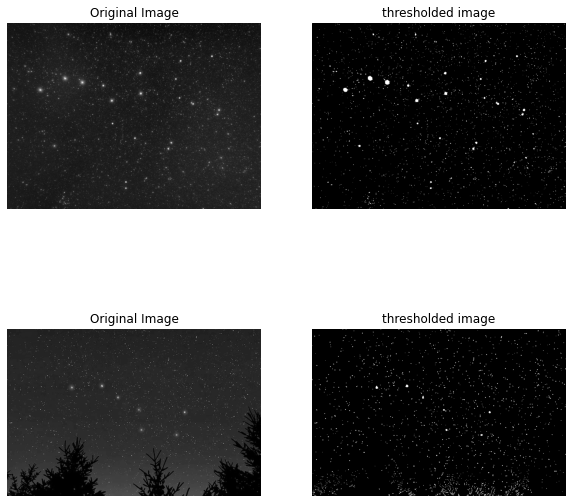

In [19]:
image1 = imageio.imread('Images/UrsaMajor/constellation-of-ursa-major-tony--daphne-hallasscience-photo-library.jpg', as_gray=True)
image2 = imageio.imread('Images/UrsaMajor/the-big-dipper.jpg', as_gray=True)

img_o1 = thresholding(image1,80)
img_o2 = thresholding(image2,80)

plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(222); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(223); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(224); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

[17.606441722114656, 29.796255612783206, 47.402697334897866]


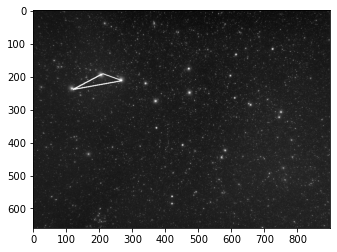

In [20]:
S = clustering(img_o1)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(image1, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

[17.833369734647416, 26.344259285354404, 44.177629020001824]


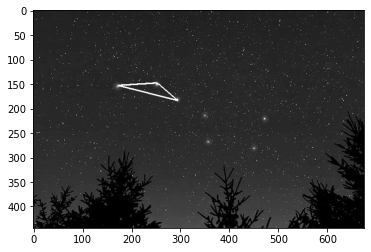

In [21]:
S = clustering(img_o2)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(image2, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

## Scorpio:



Text(0.5, 1.0, 'thresholded image')

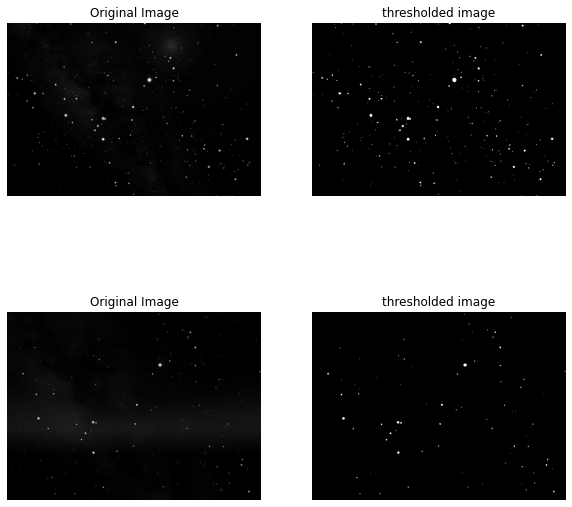

In [22]:
image1 = imageio.imread('Images/Scorpius/con_SCO_001.png', as_gray=True)
image2 = imageio.imread('Images/Scorpius/new_scorpio3.jpg', as_gray=True)

img_o1 = thresholding(image1,80)
img_o2 = thresholding(image2,80)

plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(222); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(223); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(224); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

[15.719331847562051, 27.40125130297096, 43.12058315053301]


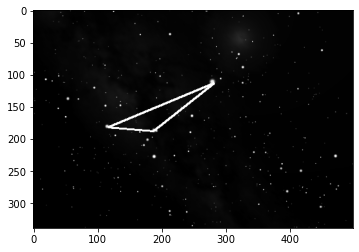

In [23]:
S = clustering(img_o1)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(image1, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])


triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

[11.579214651867268, 67.0068075770553, 78.58602222892256]


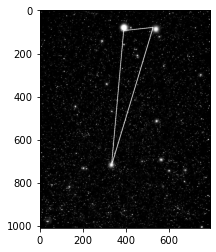

In [29]:
S = clustering(img_o2)
stars = sorted(S, key=len)
stars.reverse() 

img_line = draw_line(image2, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

## Gemini:

Text(0.5, 1.0, 'thresholded image')

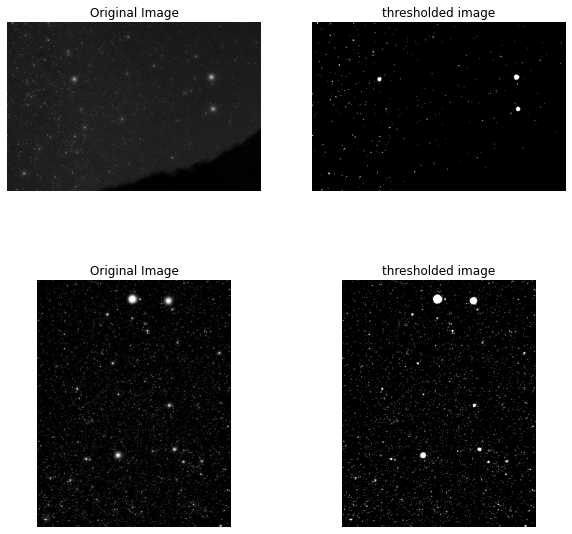

In [30]:
image1 = imageio.imread('Images/Gemini/gem4.jpg', as_gray=True)
image2 = imageio.imread('Images/Gemini/gem2.jpg', as_gray=True)

img_o1 = thresholding(image1,80)
img_o2 = thresholding(image2,80)

plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(222); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(223); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(224); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

[12.078051773409435, 68.24742039807683, 80.32547217148625]


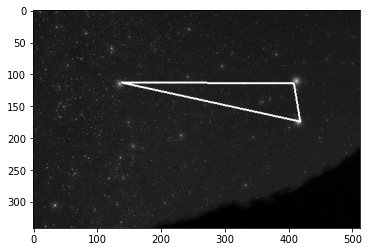

In [31]:
S = clustering(img_o1)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(image1, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

[11.579214651867268, 67.0068075770553, 78.58602222892256]


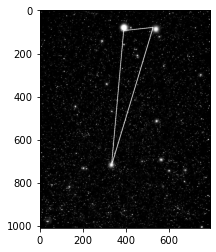

In [32]:
S = clustering(img_o2)
stars = sorted(S, key=len)
stars.reverse() 

img_line = draw_line(image2, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

triangle = triangle_angles(stars)

print(triangle)
plt.imshow(img_line, cmap="gray");

Dictionary with angles of each constellation

In [33]:
Constellations = {
    "Orion": [11, 25.4 ,36.45],
    "UrsaMinor": [21.2, 26.71, 47.84],
    "UrsaMajor": [14.97, 25.03, 40],
    "Gemini": [13.12, 75.9, 86.6],
    "Scorpius": [16.87, 27.4, 44.3]
}

Determining corresponded constellation

In [35]:
def calculaErro(triangle, expected):
    erro = abs(triangle[0] - expected[0])
    erro += abs(triangle[1] - expected[1])
    erro += abs(triangle[2] - expected[2])
    return erro/3

menorErro = 99999

for const in Constellations:
    x = Constellations[const]
    erro = calculaErro(triangle, x)
    if (erro < menorErro):
        aux = const
        menorErro = erro

print("Your constellation... " + aux)

Your constellation... Gemini
